In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os.path

In [2]:
scenarios_folder = os.path.expanduser('~/interscsimulator/scenarios/digital-rails-av-paulista/')
dr_events_filename_template = scenarios_folder + '{}/arrivals.xml'

In [3]:
def parse_arrivals(filename, prefix=''):
    tree = ET.parse(filename)
    root = tree.getroot()

    events = []
    for child in root:        
        if child.attrib['type'] == 'arrival' and (len(prefix) == 0 or (prefix in child.attrib['person'])):
            # Sample arrival event:
            # <event time="918" type="arrival" person="paraiso5_79" vehicle="paraiso5_79" 
            #     link="40" legMode="car" trip_time="205" distance="2825" action="ok"/>

            trip_time = int(child.attrib['trip_time'])
            distance = int(child.attrib['distance'])

            events.append({'trip_time_s': trip_time, 'distance_m': distance})

    return pd.DataFrame(events)

In [4]:
scenarios = [
    ('random_walk_dr_algo_0_0',    0.0, 0),
    ('random_walk_dr_algo_1_0',    0.0, 1),
#     ('random_walk_dr_algo_1_5',   0.05, 1),
#     ('random_walk_dr_algo_1_10',  0.10, 1),
#     ('random_walk_dr_algo_1_15',  0.15, 1),
#     ('random_walk_dr_algo_1_20',  0.20, 1),
    ('random_walk_dr_algo_1_25',  0.25, 1),
#     ('random_walk_dr_algo_1_30',  0.30, 1),
#     ('random_walk_dr_algo_1_35',  0.35, 1),
#     ('random_walk_dr_algo_1_40',  0.40, 1),
#     ('random_walk_dr_algo_1_45',  0.45, 1),
    ('random_walk_dr_algo_1_50',  0.50, 1),
#     ('random_walk_dr_algo_1_55',  0.55, 1),
#     ('random_walk_dr_algo_1_60',  0.60, 1),
#     ('random_walk_dr_algo_1_65',  0.65, 1),
#     ('random_walk_dr_algo_1_70',  0.70, 1),
    ('random_walk_dr_algo_1_75',  0.75, 1),
#     ('random_walk_dr_algo_1_80',  0.80, 1),
#     ('random_walk_dr_algo_1_85',  0.85, 1),
#     ('random_walk_dr_algo_1_90',  0.90, 1),
#     ('random_walk_dr_algo_1_95',  0.95, 1),
    ('random_walk_dr_algo_1_100',  1.0, 1),
]

dfs = []
for filename, ratio, dr_lanes in scenarios:
    df = parse_arrivals(dr_events_filename_template.format(filename))
    df['speed'] = 3.6 * (df['distance_m'] / df['trip_time_s'])
    df['ratio'] = ratio
    df['dr_lanes'] = dr_lanes
    dfs.append(df)
    
df = pd.concat(dfs)
df.head()

distance_m  trip_time_s      speed  ratio  dr_lanes
0          77           13  21.323077    0.0         0
1         155           18  31.000000    0.0         0
2         113           12  33.900000    0.0         0
3         208           22  34.036364    0.0         0
4         208           22  34.036364    0.0         0

In [5]:
trip_categories = 4
df['trip_category'] = pd.qcut(df['distance_m'], trip_categories)
aggs = {'distance_m': ['mean', 'std'], 'trip_time_s': ['mean', 'std'], 'speed': ['mean', 'std']}

In [6]:
gdf = df.groupby(['ratio', 'dr_lanes']).agg(aggs).sort_index()
bench_mean = df.groupby(['ratio', 'dr_lanes']).agg(aggs)['trip_time_s']['mean'].loc[0][0]
gdf

distance_m             trip_time_s                 speed  \
                      mean         std        mean        std       mean   
ratio dr_lanes                                                             
0.00  0         733.294324  657.280983   98.188649  75.994059  26.916233   
      1         734.980180  661.597739  102.480991  77.915330  25.759534   
0.25  1         743.161229  667.487490   99.021539  75.741927  27.040508   
0.50  1         738.510180  660.405254   95.252973  73.927812  28.153168   
0.75  1         743.947008  661.843962   94.429975  73.674265  28.765969   
1.00  1         732.118559  655.769591   92.079550  72.785135  29.241625   

                           
                      std  
ratio dr_lanes             
0.00  0          9.994416  
      1         10.420314  
0.25  1         10.469774  
0.50  1         10.199451  
0.75  1         10.040898  
1.00  1         10.134779

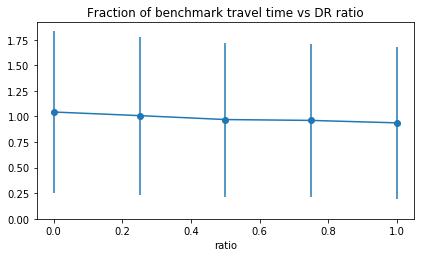

In [7]:
gdf1 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 1]
gdf0 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 0]

ax = (gdf1['trip_time_s']['mean'] / bench_mean).plot(
    yerr=(gdf1['trip_time_s']['std'] / bench_mean),
    ylim=(0, None),
    marker='o', 
    title='Fraction of benchmark travel time vs DR ratio',
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [8]:
gdf = df.groupby(['ratio', 'dr_lanes', 'trip_category']).agg(aggs).sort_index()
bench_mean = df.groupby(['ratio', 'dr_lanes', 'trip_category']).agg(aggs)['trip_time_s']['mean'].unstack('trip_category').loc[0].loc[0]
gdf

distance_m             trip_time_s  \
                                       mean         std        mean   
ratio dr_lanes trip_category                                          
0.00  0        (55.999, 208.0]   161.236192   44.509172   36.844379   
               (208.0, 560.0]    405.140773  100.286947   64.949527   
               (560.0, 947.0]    704.800284   99.972659   88.973750   
               (947.0, 2989.0]  1735.662917  538.436924  210.332958   
      1        (55.999, 208.0]   160.875401   44.534981   44.571291   
               (208.0, 560.0]    406.626312  100.216931   66.237288   
               (560.0, 947.0]    701.315640  100.443893   89.420028   
               (947.0, 2989.0]  1740.408650  543.063792  216.967562   
0.25  1        (55.999, 208.0]   160.662809   45.075939   39.291868   
               (208.0, 560.0]    404.492742  100.334876   64.150145   
               (560.0, 947.0]    702.539385  100.892605   87.959732   
               (947.0, 2989.0]  1743.410135  541.065964  208.831936   
0.50  1        (55.999, 208.0]   161.189744   43.816977   34.024359   
               (208.0, 560.0]    410.947171  101.882212   63.693428   
               (560.0, 947.0]    704.631799  102.497112   86.993724   
               (947.0, 2989.0]  1730.336041  548.556583  202.560931   
0.75  1        (55.999, 208.0]   160.990073   45.016065   30.517207   
               (208.0, 560.0]    404.056071   99.806967   63.062929   
               (560.0, 947.0]    704.621366  100.949962   87.623468   
               (947.0, 2989.0]  1735.392336  536.719093  200.391971   
1.00  1        (55.999, 208.0]   161.730499   44.326606   29.120524   
               (208.0, 560.0]    407.152392  100.586309   63.073181   
               (560.0, 947.0]    702.544996   96.874920   86.344132   
               (947.0, 2989.0]  1720.120059  540.462273  197.364980   

                                               speed             
                                      std       mean        std  
ratio dr_lanes trip_category                                     
0.00  0        (55.999, 208.0]  20.242344  20.433806   9.921909  
               (208.0, 560.0]   29.220710  26.102489  10.170250  
               (560.0, 947.0]   36.171287  31.757444   8.796405  
               (947.0, 2989.0]  57.518960  30.054289   6.189661  
      1        (55.999, 208.0]  24.817928  17.703877   9.957613  
               (208.0, 560.0]   28.056797  25.461299  10.116110  
               (560.0, 947.0]   36.910878  31.534929   8.834086  
               (947.0, 2989.0]  62.073431  29.302815   5.867844  
0.25  1        (55.999, 208.0]  22.927069  20.019052  10.768690  
               (208.0, 560.0]   28.390794  26.295294  10.255056  
               (560.0, 947.0]   36.166807  32.020311   8.842457  
               (947.0, 2989.0]  57.029730  30.519414   6.689411  
0.50  1        (55.999, 208.0]  20.355782  22.759678  11.183159  
               (208.0, 560.0]   28.452025  26.731124   9.928734  
               (560.0, 947.0]   35.040153  32.284391   8.676979  
               (947.0, 2989.0]  55.812688  31.254324   7.221948  
0.75  1        (55.999, 208.0]  17.936006  24.539059  11.262427  
               (208.0, 560.0]   29.245752  26.883644  10.123174  
               (560.0, 947.0]   34.594701  32.018242   8.674245  
               (947.0, 2989.0]  54.163131  31.742163   7.387318  
1.00  1        (55.999, 208.0]  17.520818  25.736165  11.454262  
               (208.0, 560.0]   29.437887  26.994663   9.976840  
               (560.0, 947.0]   35.279209  32.579476   8.903337  
               (947.0, 2989.0]  53.129739  31.931217   7.705055

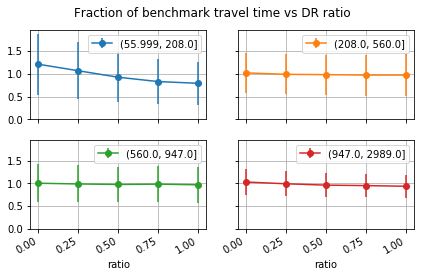

In [9]:
gdf1 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 1]
gdf0 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 0]

ax = (gdf1['trip_time_s']['mean'].unstack('trip_category') / bench_mean).plot(
    yerr=(gdf1['trip_time_s']['std'].unstack('trip_category') / bench_mean),
    ylim=(0, None),
    marker='o', 
    title='Fraction of benchmark travel time vs DR ratio',
    subplots=True,
    layout=(2,2),
    sharey=True,
    grid=True,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])